In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
from thermography_dataset_one_layer import ThermDataset
from sklearn.model_selection import train_test_split
%matplotlib inline

In [52]:
args = {'lr':0.01,
        'epochs':1000,
        'noise':0.01,
        'train size':0.7,
        'spec scale':10**12,
        'dropout':0.90
        }

In [53]:
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

# Prepare Data

In [54]:
df = pd.read_excel('wide_range.xlsx')

In [55]:
X = df.iloc[:,11:]
y = df.iloc[:,:11]

In [56]:
# scale by 10^12
X = X.apply(lambda x: x*args['spec scale'])

# add noise
noise = np.random.normal(loc=0, scale=args['noise'], size=X.shape)
X = X + noise

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=args['train size'], random_state=101)

In [58]:
X_train.index = range(len(X_train))
X_test.index = range(len(X_test))

# Design Models

In [59]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(input_size, 45)
        self.lin2 = nn.Linear(45, 60)
        self.lin3 = nn.Linear(60, 75)
        self.lin4 = nn.Linear(75, 60)
        self.lin_fin = nn.Linear(60, output_size)
        self.dropout = nn.Dropout(args['dropout'])


    def forward(self, x):
        x = self.dropout(x)
        x = F.leaky_relu(self.lin1(x))
        x = F.leaky_relu(self.lin2(x))
        x = F.leaky_relu(self.lin3(x))
        x = F.leaky_relu(self.lin4(x))
        x = self.lin_fin(x)
        return x

In [60]:
input_size = len(X_train.columns)
output_size = 1

# store models in descending order (11, 10, 9...)
models = []
for i in range(11):
    models.append(Net(input_size+i, output_size))

# Training Loops

In [61]:
learning_rate = args['lr']
criterion = nn.L1Loss()

In [62]:
best_losses = []

for i in range(11):
    best_loss = np.inf
    best_epoch = 0

    print(f'Layer {11-i}')

    optimizer = torch.optim.Adam(models[i].parameters(), lr=learning_rate)
    model = models[i]

    inputs = df_to_tensor(X_train)
    outputs = df_to_tensor(y_train.iloc[:,10-i]).reshape(-1,1)

    for epoch in range(args['epochs']):
        # empty gradients
        optimizer.zero_grad()

        # forward pass
        pred = model(inputs)

        # loss
        loss = criterion(pred, outputs)

        # backward pass
        loss.backward()
        
        # update
        optimizer.step()

        #if (epoch+1) % int(args['epochs']/10) == 0:
        #    print(f'epoch: {epoch+1}, loss = {loss}')

        if loss < best_loss:
            best_loss = loss
            best_epoch = epoch + 1

    best_losses.append(best_loss.item())
    
    X_train[f'layer {11-i} predictions'] = pd.DataFrame(pred.detach().numpy())
    print(X_train.columns)
    #print(f'best loss: {best_loss} in epoch {best_epoch}\n')


Layer 11
Index([              3.75e-06,                3.8e-06,               3.85e-06,
                      3.9e-06,               3.95e-06,                  4e-06,
                     4.05e-06,                4.1e-06,               4.15e-06,
                      4.2e-06,               4.25e-06,                4.3e-06,
                     4.35e-06,                4.4e-06,               4.45e-06,
                      4.5e-06,               4.55e-06,                4.6e-06,
                     4.65e-06,                4.7e-06,               4.75e-06,
                      4.8e-06,               4.85e-06,                4.9e-06,
                     4.95e-06,                  5e-06,               5.05e-06,
                      5.1e-06,               5.15e-06,                5.2e-06,
                     5.25e-06,                5.3e-06,               5.35e-06,
                      5.4e-06,               5.45e-06,                5.5e-06,
                     5.55e-06,             

KeyboardInterrupt: 

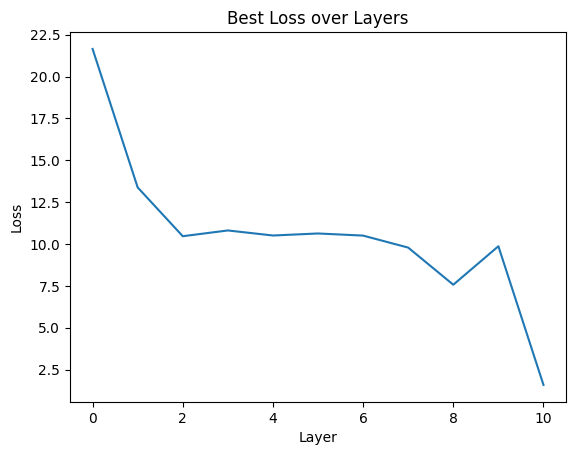

In [ ]:
best_losses.reverse()
plt.plot(best_losses)

plt.title("Best Loss over Layers")
plt.xlabel("Layer")
plt.ylabel("Loss")
plt.show()

# Testing

In [ ]:
def get_predictions(X_test):
    df = X_test.copy()

    predictions = []

    for i in range(11):
        inputs = df_to_tensor(df)
        pred = models[i](inputs)

        predictions.append(pred)
        df[f'layer {11-i} predictions'] = pd.DataFrame(pred.detach().numpy())

    return df.loc[:, 'layer 11 predictions':'layer 1 predictions'], predictions

In [ ]:
def test_models(X_test):
    _, predictions = get_predictions(X_test)

    layer = 11
    for pred in predictions:
        actual = df_to_tensor(y_test.iloc[:,layer-1]).reshape(-1,1)
        loss = criterion(pred, actual)
        print(f'layer {layer} loss: {loss:.3f}')
        layer -= 1


In [ ]:
test_models(X_test)

layer 11 loss: 5.152
layer 10 loss: 10.087
layer 9 loss: 17.227
layer 8 loss: 12.089
layer 7 loss: 13.955
layer 6 loss: 13.326
layer 5 loss: 14.009
layer 4 loss: 14.512
layer 3 loss: 13.421
layer 2 loss: 15.754
layer 1 loss: 22.708
